In [1]:
import secrets
import pandas as pd
import numpy as np
#import seaborn as sns

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

from abc import ABC, abstractmethod
from dataclasses import dataclass

#sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:
import model.basic_model as basic_model
from model.stochastic_processes import (
    create_stochastic_process,
    plot_price,
)
from model.agents import (
    CEXAgent, LSTAgent, LRTAgent, SoloAgent, StakingPoolAgent, ETFAgent,
    StandardDeposit, StandardFullWithdraw
)
import model.agents_decision as agents_decision
import model.infra_costs as infra_costs
import model.APY as APY

In [4]:
import os
import sys
print("Current Working Directory:", os.getcwd())
print("Python Path:", sys.path)


Current Working Directory: /Users/amber/Desktop/Simulation/MVI-cyberFund
Python Path: ['/Users/amber/Desktop/Simulation/MVI-cyberFund', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/amber/Desktop/Simulation/venv/lib/python3.9/site-packages']


In [5]:
# types
Run = int
Timestep = int

# Price Traj Generation

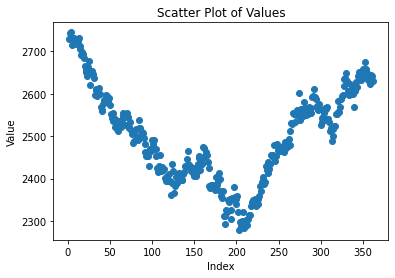

2278.6599203135465


In [6]:
eth_price_samples = create_stochastic_process(price_traj_type = 'concave')
eth_price_samples = [i for i in eth_price_samples] # ETH-USD pair
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [7]:
constants = {
}

In [8]:
cumu_staked = pd.read_csv('model/data/cumu_staked_validator.csv')

recent_staked = cumu_staked[cumu_staked['day']==cumu_staked['day'].max()]
curr_stake_LRT = recent_staked[recent_staked['entity_category']=='Liquid Restaking']['curr_stake']
curr_stake_LST = recent_staked[recent_staked['entity_category']=='Liquid Staking']['curr_stake']
curr_stake_CEX = recent_staked[recent_staked['entity_category']=='CEXs']['curr_stake']
curr_stake_Solo = recent_staked[recent_staked['entity_category']=='Solo Stakers']['curr_stake']
curr_stake_SP = recent_staked[recent_staked['entity_category']=='Staking Pools']['curr_stake']

In [9]:
recent_staked

,amount_full_withdrawn,amount_partial_withdrawn,amount_staked,cumulative_amount_full_withdrawn,cumulative_amount_partial_withdrawn,cumulative_amount_staked,cumulative_total_entries,curr_stake,day,entity_category,total_entries
0,960.0,171.572760,0,1.075039e+06,39889.195288,3753443,2077937,2.638515e+06,2024-09-24,Liquid Restaking,7487
1,3680.0,123.906669,1504,1.776657e+06,368449.555773,6096346,8953090,3.951240e+06,2024-09-24,undefined,5607
2,2272.0,175.889942,1216,6.394754e+06,803357.335542,9701248,17951774,2.503136e+06,2024-09-24,CEXs,7827
3,736.0,270.989009,1696,3.853881e+06,329806.532933,8021376,9539748,3.837688e+06,2024-09-24,Staking Pools,11989
4,32.0,0.383541,0,1.202491e+05,44379.896161,109794,767849,-5.483503e+04,2024-09-24,Solo Stakers,21
5,672.0,247.529829,15185,3.104268e+06,723657.330501,9457080,22516484,5.629155e+06,2024-09-24,Liquid Staking,11346


In [10]:
# Initialize an agent
cex_agent = CEXAgent(
    balance=curr_stake_CEX, 
    cnt=int(curr_stake_CEX/32), 
    category="CEX", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lst_agent = LSTAgent(
    balance=curr_stake_LST, 
    cnt=int(curr_stake_LST/32), 
    category="LST", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lrt_agent = LRTAgent(
    balance=curr_stake_LRT, 
    cnt=int(curr_stake_LRT/32), 
    category="LRT", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

solo_agent = SoloAgent(
    balance=curr_stake_Solo, 
    cnt=int(curr_stake_Solo/32), 
    category="Solo", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

sp_agent = StakingPoolAgent(
    balance=curr_stake_SP, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

etf_agent = ETFAgent(
    balance=0, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

<ipython-input-10-f3800099faa3>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_CEX/32),
<ipython-input-10-f3800099faa3>:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LST/32),
<ipython-input-10-f3800099faa3>:28: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LRT/32),
<ipython-input-10-f3800099faa3>:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_Solo/32),
<ipython-input-10-f3800099faa3>:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt

# Simulation

In [11]:
ETH_initial_price = eth_price_samples[0]


In [12]:
@dataclass
class MVIParams:

    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

parameters = MVIParams().__dict__

In [13]:
psub = [{
    "policies": {
    },
    "variables": {
        "timestep": basic_model.update_timestep,
        "price": basic_model.update_price,
    }
},  { # TODO: utility function and decision making
    "policies": {
        "action": agents_decision.deposit_withdraw
    },
    "variables": {
        "CEXAgent": agents_decision.update_CEXAgent_deposit_withdraw,
        "LSTAgent": agents_decision.update_LSTAgent_deposit_withdraw,
        "LRTAgent": agents_decision.update_LRTAgent_deposit_withdraw,
        "SoloAgent": agents_decision.update_SoloAgent_deposit_withdraw,
        "StakingPoolAgent": agents_decision.update_StakingPoolAgent_deposit_withdraw,
    }
},  { # TODO: double check the infra costs
    "policies": { 
        "action": infra_costs.calc_costs
    },
    "variables": {
        "CEXAgent": infra_costs.update_CEXAgent_cost,
        "LSTAgent": infra_costs.update_LSTAgent_cost,
        "LRTAgent": infra_costs.update_LRTAgent_cost,
        "SoloAgent": infra_costs.update_SoloAgent_cost,
        "StakingPoolAgent": infra_costs.update_StakingPoolAgent_cost,
    }
},  { # TODO: highlight profits
    "policies": {
        "action": APY.calc_decentralization_and_total_staked
    },
    "variables": {
        "total_staked": APY.update_total_staked,
        "total_validator_cnt": APY.update_total_validator_cnt,
        "decentralization_metrics": APY.update_decentralization_metrics,
    }
}
]

initial_conditions = {
    "timestep": 0,
    "price": ETH_initial_price, 
    "CEXAgent": cex_agent,
    "LSTAgent": lst_agent,
    "LRTAgent": lrt_agent,
    "SoloAgent": solo_agent,
    "StakingPoolAgent": sp_agent,
    "ETFAgent": etf_agent,
    "total_staked": 0,
    "total_validator_cnt": 0,
    "decentralization_metrics": {},
}


params = parameters

model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params,
    )

In [14]:
simulation = Simulation(model=model, timesteps=100, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, backend=Backend.SINGLE_PROCESS)
results = experiment.run()
df = pd.DataFrame(results)

Timestep: 1, Available data: 150
Timestep: 2, Available data: 150
Timestep: 3, Available data: 150
Timestep: 4, Available data: 150
Timestep: 5, Available data: 150
Timestep: 6, Available data: 150
Timestep: 7, Available data: 150
Timestep: 8, Available data: 150
Timestep: 9, Available data: 150
Timestep: 10, Available data: 150
Timestep: 11, Available data: 150
Timestep: 12, Available data: 150
Timestep: 13, Available data: 150
Timestep: 14, Available data: 150
Timestep: 15, Available data: 150
Timestep: 16, Available data: 150
Timestep: 17, Available data: 150
Timestep: 18, Available data: 150
Timestep: 19, Available data: 150
Timestep: 20, Available data: 150
Timestep: 21, Available data: 150
Timestep: 22, Available data: 150
Timestep: 23, Available data: 150
Timestep: 24, Available data: 150
Timestep: 25, Available data: 150
Timestep: 26, Available data: 150
Timestep: 27, Available data: 150
Timestep: 28, Available data: 150
Timestep: 29, Available data: 150
Timestep: 30, Available

In [15]:
df

,timestep,price,CEXAgent,LSTAgent,LRTAgent,SoloAgent,StakingPoolAgent,ETFAgent,total_staked,total_validator_cnt,decentralization_metrics,simulation,subset,run,substep
0,0,2729.738442,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",0.0,0.0,{},0,0,1,0
1,1,2729.738442,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",0.0,0.0,{},0,0,1,1
2,1,2729.738442,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",0.0,0.0,{},0,0,1,2
3,1,2729.738442,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",0.0,0.0,{},0,0,1,3
4,1,2729.738442,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",18472512.0,577266.0,"{'HHI': 2197.0178589361512, 'CR_k': 0.72259062...",0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,99,2465.804908,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",26786240.0,837070.0,"{'HHI': 2133.258649067451, 'CR_k': 0.702515918...",0,0,1,4
397,100,2490.373304,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",26786240.0,837070.0,"{'HHI': 2133.258649067451, 'CR_k': 0.702515918...",0,0,1,1
398,100,2490.373304,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",26786240.0,837070.0,"{'HHI': 2133.258649067451, 'CR_k': 0.702515918...",0,0,1,2
399,100,2490.373304,CEXAgent(balance=2 5.058752e+06\nName: curr...,LSTAgent(balance=5 7.522083e+06\nName: curr...,LRTAgent(balance=0 4.166419e+06\nName: curr...,SoloAgent(balance=4 -21235.0305\nName: curr_...,StakingPoolAgent(balance=3 6.308120e+06\nNa...,"ETFAgent(balance=0, cnt=119927, category='SP',...",26786240.0,837070.0,"{'HHI': 2133.258649067451, 'CR_k': 0.702515918...",0,0,1,3


In [16]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
    0: "normal",
}
)

In [17]:
visualizations.plot_total_staked(
    df,
    scenario_names={
    0: "normal",
}
)

In [18]:
visualizations.plot_hhi(
    df,
    scenario_names={
    0: "normal",
}
)